### 1. Loading data set and the required libraries


In [1]:
### 1. Loading the libraries and required libraries 
# Importing ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
sns.set()

In [2]:
# Loading the Instacart datasets into pandas dataframes
from google.colab import drive 
drive.mount('/content/gdrive')
instacart_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Algo/3. Clustering/K-means clustering/instacart.csv', dtype={'product_name':'object', 
                                                               'aisle_id':'int16',
                                                               'department_id':'int16',
                                                               'num_orders':'int32',
                                                               'num_reordered':'int64',
                                                               'reorder_rate':'float32',
                                                               'add_to_cart_mean':'float32',
                                                               'order_mean_dow':'float32', 
                                                               'order_mean_hour_of_day':'float32', #could also be category
                                                               'mean_day_gap_in_orders':'float32'})



Mounted at /content/gdrive


In [3]:
#Let's explore the data and the associated columns.
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000


In [4]:
#Checking for null values
instacart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13377 entries, 0 to 13376
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_name            13377 non-null  object 
 1   aisle_id                13377 non-null  int16  
 2   department_id           13377 non-null  int16  
 3   num_orders              13377 non-null  int32  
 4   num_reordered           13377 non-null  int64  
 5   reorder_rate            13377 non-null  float32
 6   add_to_cart_mean        13377 non-null  float32
 7   order_mean_dow          13377 non-null  float32
 8   order_mean_hour_of_day  13377 non-null  float32
 9   mean_day_gap_in_orders  13377 non-null  float32
dtypes: float32(5), int16(2), int32(1), int64(1), object(1)
memory usage: 574.9+ KB


In [5]:
# Aisle and department are categorical variables. Let us check the numbers of categories they have
instacart_df['aisle_id'].nunique(), instacart_df['department_id'].nunique()

(134, 21)

aisle_id column has 134 categories, and the department_id column has 21. When forming clusters, categorical variables with a low number of values could help the algorithm deliver better results by adding another dimension. But since, in this case, the number of categories is high, it won't add value to the clustering quality by the algorithm.

Let's see how the Python sees these data points:

In [6]:
#Using the describe function to check data distribution of the dataset
instacart_df.describe()

,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
count,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000
mean,70.670255,11.396651,96.935113,59.192794,0.514981,9.283619,2.762032,13.604996,17.284019
std,38.380694,6.267054,372.921094,290.603486,0.175570,2.232181,0.444830,0.865992,2.429661
min,1.000000,1.000000,11.000000,0.000000,0.000000,2.125000,0.636364,8.714286,6.363000
25%,37.000000,6.000000,17.000000,8.000000,0.400000,7.900000,2.500000,13.125000,15.810000
50%,77.000000,13.000000,31.000000,15.000000,0.533333,9.327868,2.745763,13.591837,17.219999
75%,106.000000,16.000000,72.000000,39.000000,0.642857,10.646153,3.000000,14.086957,18.750000
max,134.000000,21.000000,18726.000000,16557.000000,1.000000,19.590910,5.000000,17.562500,29.230000


Some of the interesting insights from the data distribution pattern are as follows: 

*   order_mean_dow indicates that the initial days of the week have low traction.
*   order_mean_hour_of_day shows that the majority of orders start coming in post noon.




In [11]:
focussed_data = instacart_df[['num_orders', 'reorder_rate']].copy()
#Let's scale these values for our clustering algorithm, we'll call this data frame 'scaled_df1'.
#Scaling the values using the sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()   


In [12]:
#Printing values after scaling
scaled_df1[:5]

array([[-0.05614028,  0.73908156],
       [-0.20094844,  0.69138824],
       [-0.22508314,  0.13374316],
       [ 0.05916992,  0.41725189],
       [-0.22508314, -0.30440686]])

### Building Clustering Models - Part II
#### **2. DBSCAN**

Now that we have analyzed the clustering outputs using the K-Means algorithm, let's give DBSCAN algorithm a try to see if it could perform better.

We will be using 2-dimensional data created earlier for this demo.

In [13]:
#Scaling the variables and storing them in a new data frame to start afresh
temp2_scaled = scaler.fit_transform(focussed_data[['num_orders', 'reorder_rate']])

In [14]:
temp2_scaled = pd.DataFrame(temp2_scaled)
temp2_scaled.columns = ['F1', 'F2']
temp2_scaled.head()

,F1,F2
0,-0.056140,0.739082
1,-0.200948,0.691388
2,-0.225083,0.133743
3,0.059170,0.417252
4,-0.225083,-0.304407


In [15]:
from sklearn.cluster import DBSCAN


Recall that just as we find an optimal value for *K* for the Kmeans algorithm, we have *epsilon* and the minimum number of data points *MinPts* parameters to initialize for the DBSCAN algorithm.

Let's see how to find the optimal value for the eps(Epsilon) parameter for our use case:

Assume a value for MinPts, which is the same as k for k-nearest neighbors determination for a given point.
*   Step 1: Calculate the average of distances from a data point to its k nearest neighbors (kNN)
*   Step 2: Plot the average kNN distances for the data points in ascending order
* Step 3: Determine the focus point (elbow) with the highest curvature
* Step 4: (If required) Zoom into that range to find the optimal value for the Epsilon

Let's start with finding the optimal value for Epsilon first:



#####Finding Optimal value for Epsilon

We need to find a value of epsilon; let's plot distances against data points.

In [16]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(temp2_scaled)
distances, indices = nbrs.kneighbors(temp2_scaled)
print(np.shape(distances))
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(temp2_scaled)
distances, indices = neighbors_fit.kneighbors(temp2_scaled)


(13377, 4)


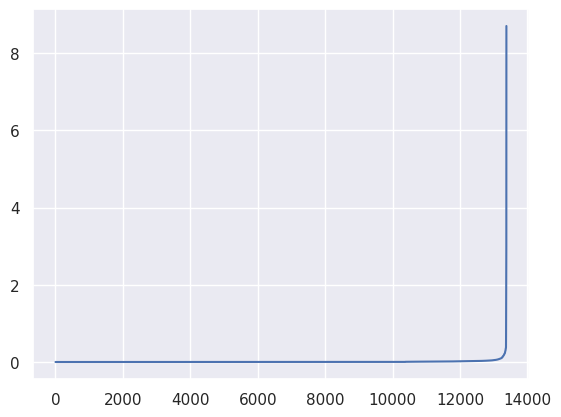

In [17]:
# Step 3: Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [18]:
te1=pd.DataFrame(distances)
te1

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
13372,2.049149
13373,2.982752
13374,2.982752
13375,8.705401


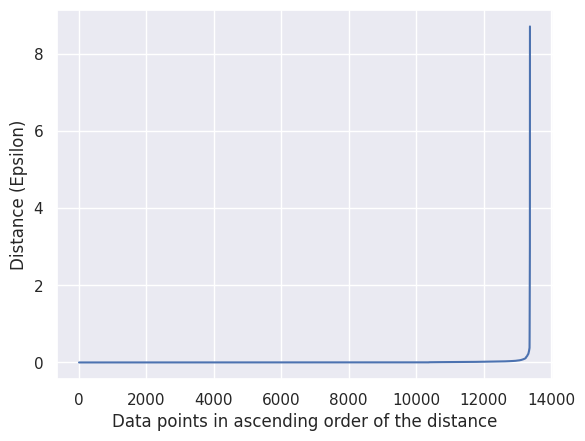

In [19]:
distances = np.sort(distances, axis=0)
#distances = distances[:,1]
plt.plot(distances)
plt.ylabel("Distance (Epsilon)")
plt.xlabel("Data points in ascending order of the distance")
plt.show()


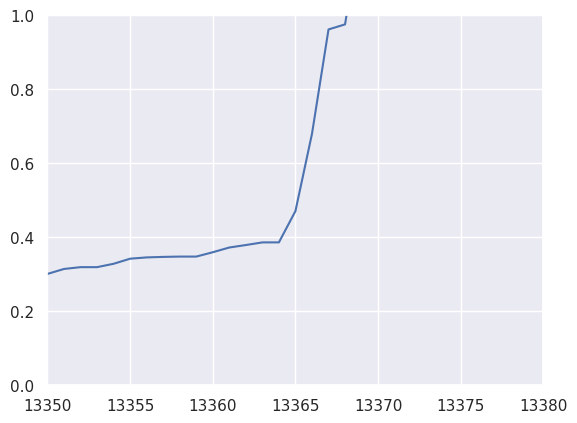

In [20]:
#Zooming into the area of interest
plt.plot(distances)
plt.xlim([13350,13380])
#plt.xlim([13374,13380])
plt.ylim([0,1])
plt.show()


As the plot above shows, there is an elbow point at a distance value of around 0.5, so we can take eps=0.5.

##### Determining the MinPts value:
There is no plotting method or an automatic indicator to find a value for the MinPts parameter. 

A general rule of thumb based on the research done in this area entails the following:

*   Choose a large MinPts value if dataset has noise
*   For larger datasets choose MinPts = 2*(number of dimensions) (Sander et al., 1998)
* For 2D datasets, choose MinPts value = 4 (Ester et al., 1996)



In [21]:
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=4).fit(temp2_scaled)
labels = db.labels_

instacart_df['cluster_label_dbscan'] = db.labels_

In [22]:
# Please note that the label -1 is designated for outliers and the rest of the labels are used for the clusters formed
np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([   20, 13349,     8]))

In [23]:
# Building the label to colour mapping
colours = {}
colours[0] = 'r'
colours[1] = 'g'
#colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]

In [24]:
r = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='r');
g = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='g');
#b = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='b');
k = plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], color ='k');
plt.clf()

<Figure size 640x480 with 0 Axes>

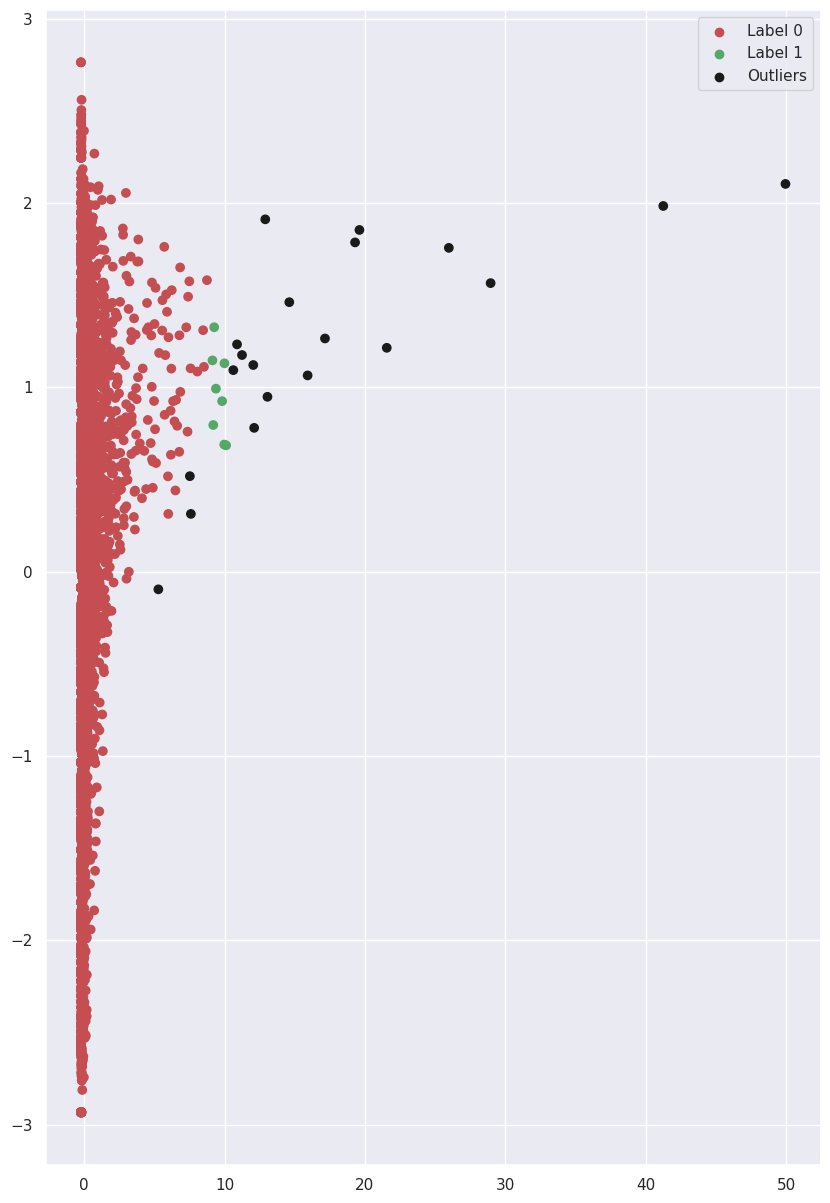

In [25]:
plt.figure(figsize =(10, 15))
plt.scatter(temp2_scaled['F1'], temp2_scaled['F2'], c = cvec)

# plt.yscale("symlog")

# Building the legend
plt.legend([r, g, k], ['Label 0', 'Label 1', 'Outliers'])
  
plt.show()

# DBSCAN formed 2 clusters and identified outliers as well!

In [26]:
(instacart_df.groupby('cluster_label_dbscan')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     ))

,num_products_in_cluster,mean_num_orders,mean_reorder_rate
cluster_label_dbscan,,,
-1,20,6764.100000,0.734811
0,13349,84.798037,0.514551
1,8,3681.250000,0.683664
